In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, models, transforms
from facenet_pytorch import fixed_image_standardization, MTCNN
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import zipfile
import cv2
from PIL import Image, ImageOps
import gdown
from pillow_heif import register_heif_opener
from tqdm import tqdm
from collections import defaultdict

In [ ]:
url = 'https://drive.google.com/file/d/1tDo2zQC_1ZKY8aMYaalgr6nxRmBcRxaO/view?usp=drive_link'
output_filename = 'downloaded_file.zip'
gdown.download(url, output_filename, quiet=False, fuzzy=True)
print(f"\nDownload selesai! Disimpan sebagai: {output_filename}")

Downloading...
From (original): https://drive.google.com/uc?id=1tDo2zQC_1ZKY8aMYaalgr6nxRmBcRxaO
From (redirected): https://drive.google.com/uc?id=1tDo2zQC_1ZKY8aMYaalgr6nxRmBcRxaO&confirm=t&uuid=984c2be8-81fd-41e6-a5f8-b43e3ff01921
To: /content/downloaded_file.zip
100%|██████████| 428M/428M [00:03<00:00, 130MB/s]


Download selesai! Disimpan sebagai: downloaded_file.zip


In [ ]:
zip_path = 'downloaded_file.zip'
extract_path = 'dataset_unzipped'
os.makedirs(extract_path, exist_ok=True)

print(f"Mengekstrak '{zip_path}'...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Ekstraksi selesai.")

Mengekstrak 'downloaded_file.zip'...
Ekstraksi selesai.


In [ ]:
register_heif_opener()

def convert_heic_to_jpg(root_folder, delete_original=True):
    print(f"Mencari file HEIC di:dataset_unzipped/Train...")
    converted_count = 0

    for root, dirs, files in os.walk('dataset_unzipped/Train'):
        for file in files:
            if file.lower().endswith(".heic"):
                heic_path = os.path.join(root, file)

                jpg_path = os.path.splitext(heic_path)[0] + ".jpg"

                try:
                    image = Image.open(heic_path)

                    image = image.convert("RGB")
                    image.save(jpg_path, "JPEG", quality=90)

                    converted_count += 1

                    if delete_original:
                        os.remove(heic_path)

                except Exception as e:
                    print(f"Gagal mengonversi {file}: {e}")

    print(f"\nSelesai! {converted_count} file berhasil dikonversi ke JPG.")

DATASET_DIR = "Train"

convert_heic_to_jpg(DATASET_DIR, delete_original=True)

Mencari file HEIC di:dataset_unzipped/Train...

Selesai! 4 file berhasil dikonversi ke JPG.


In [ ]:
DATASET_DIR = 'dataset_unzipped/Train'

print("Mengonversi WEBP ke JPG...")

for root, dirs, files in os.walk(DATASET_DIR):
    for file in files:
        if file.lower().endswith(".webp"):
            webp_path = os.path.join(root, file)
            jpg_path = os.path.splitext(webp_path)[0] + ".jpg"

            try:
                im = Image.open(webp_path).convert("RGB")
                im.save(jpg_path, "JPEG", quality=95)

                os.remove(webp_path)
                print(f"Converted: {file}")
            except Exception as e:
                print(f"Gagal convert {file}: {e}")

print("Selesai konversi WebP!")

Mengonversi WEBP ke JPG...
Converted: 8d75deaa5e9cb8b38b51b1e7ccddf6fe_1728758888771_0.webp - Raditya Erza Farandi.webp
Converted: 29226d12f5cfbf90a5f75028c8a794ae_1744472103609_0.webp - Raditya Erza Farandi.webp
Converted: IMG_20240320_110842_570 - Alief Fathur Rahman.webp
Converted: temp_image_F4A45BFD-5507-4426-8E53-4E95A2709B45 - NASYA AULIA EFENDI.webp
Converted: temp_image_5BD313DA-028B-4E44-92B4-98405A6C90DA - NASYA AULIA EFENDI.webp
Converted: IMG_20231217_111304_702 - MARTUA KEVIN ANDREAS MUAL H LUBIS.webp
Converted: IMG_20250423_144348_683 - Intan Permata Sari.webp
Converted: IMG_20250801_111220_207 - Intan Permata Sari.webp
Converted: IMG_20240410_112254_085 - Intan Permata Sari.webp
Converted: IMG_20250224_170010_146 - Intan Permata Sari.webp
Selesai konversi WebP!


In [ ]:
SOURCE_DIR = 'dataset_unzipped/Train'
DEST_DIR = 'dataset_unzipped/Data_Cropped'
IMG_SIZE = 160  # Ukuran native InceptionResnetV1
PADDING_RATIO = 0.20

# Setup Device (MTCNN bisa lari di GPU, jauh lebih cepat)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device untuk deteksi: {device}")
mtcnn = MTCNN(
    keep_all=True,
    device=device,
    min_face_size=20,
    thresholds=[0.4, 0.5, 0.5],
    margin=0
)

Menggunakan device untuk deteksi: cuda:0


In [ ]:
def crop_face_mtcnn(image_path, padding_ratio=0.2):
    try:
        img = Image.open(image_path).convert('RGB')

        img = ImageOps.exif_transpose(img)

    except Exception:
        return None

    # Deteksi Wajah
    try:
        boxes, probs = mtcnn.detect(img)
    except Exception:
        return None

    if boxes is None:
        return None

    # Cari Wajah Terbaik (Kombinasi Luas Terbesar & Confidence Tinggi)
    best_box = None
    max_score = 0

    for box, prob in zip(boxes, probs):
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1
        area = w * h

        score = area * prob

        if score > max_score:
            max_score = score
            best_box = box

    if best_box is None:
        return None

    # Proses Crop dengan Padding
    x1, y1, x2, y2 = best_box
    w = x2 - x1
    h = y2 - y1

    img_w, img_h = img.size

    pad_x = int(w * padding_ratio)
    pad_y = int(h * padding_ratio)

    # Koordinat baru
    new_x1 = max(0, int(x1 - pad_x))
    new_y1 = max(0, int(y1 - pad_y))
    new_x2 = min(img_w, int(x2 + pad_x))
    new_y2 = min(img_h, int(y2 + pad_y))

    if new_x2 <= new_x1 or new_y2 <= new_y1:
        return None

    # Crop
    cropped_face = img.crop((new_x1, new_y1, new_x2, new_y2))

    return cropped_face

In [ ]:
if not os.path.exists(DEST_DIR):
    os.makedirs(DEST_DIR)

print(f"Memulai proses cropping dengan MTCNN (PyTorch)...")

# Ambil folder kelas
classes = [d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, d))]

for class_name in classes:
    class_path = os.path.join(SOURCE_DIR, class_name)
    dest_class_path = os.path.join(DEST_DIR, class_name)
    os.makedirs(dest_class_path, exist_ok=True)

    # Filter ekstensi gambar
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')
    images = [f for f in os.listdir(class_path) if f.lower().endswith(valid_extensions)]

    print(f"\nMemproses kelas: {class_name} ({len(images)} gambar)...")

    valid_count = 0
    skipped_count = 0

    for img_name in tqdm(images, unit="img"):
        save_path = os.path.join(dest_class_path, img_name)

        # Skip jika sudah ada (Resume capability)
        if os.path.exists(save_path):
            valid_count += 1
            continue

        img_path = os.path.join(class_path, img_name)

        # PANGGIL FUNGSI MTCNN
        cropped_img = crop_face_mtcnn(img_path, padding_ratio=PADDING_RATIO)

        if cropped_img is not None:
            # Resize ke target (160x160 untuk InceptionResnetV1)
            cropped_img = cropped_img.resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)

            # Simpan
            # Pastikan convert RGB sebelum save (jika input ada alpha channel)
            cropped_img.convert('RGB').save(save_path, quality=95)
            valid_count += 1
        else:
            skipped_count += 1

    print(f"  -> Selesai. Disimpan: {valid_count}, Skip: {skipped_count}")

print(f"\nSelesai! Dataset siap di: {DEST_DIR}")

Memulai proses cropping dengan MTCNN (PyTorch)...

Memproses kelas: Bezalel Samuel Manik (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.38img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: hayyatul fajri (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.58img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Arkan Hariz Chandrawinata Liem (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  7.21img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Fajrul Ramadhana Aqsa (4 gambar)...


100%|██████████| 4/4 [00:00<00:00, 12.02img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Mychael Daniel N (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.81img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Kenneth Austin Wijaya (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  9.30img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Raditya Erza Farandi (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.14img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Zefanya Danovanta Tarigan (4 gambar)...


100%|██████████| 4/4 [00:07<00:00,  1.83s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: JP. Rafi Radiktya Arkan. R. AZ (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.17img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Ferdana Al Hakim (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.80img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Dyo Dwi Carol Bukit (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  6.28img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Ikhsannudin Lathief (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  8.91img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Joyapul Hanscalvin Panjaitan (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  4.20img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Fayyadh Abdillah (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.90img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Gabriella Natalya Rumapea (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.71img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Joshua Palti Sinaga (8 gambar)...


100%|██████████| 8/8 [00:10<00:00,  1.36s/img]


  -> Selesai. Disimpan: 8, Skip: 0

Memproses kelas: Dwi Arthur Revangga (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  7.03img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Fiqri Aldiansyah (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.73img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Zaky Ahmad Makarim (4 gambar)...


100%|██████████| 4/4 [00:05<00:00,  1.28s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Royfran Roger Valentino (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  6.38img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Desty Ananta Purba (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.15img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Abu Bakar Siddiq Siregar (4 gambar)...


100%|██████████| 4/4 [00:00<00:00, 10.35img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Femmy Aprillia Putri (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.79img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Bayu Ega Ferdana (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  5.45img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Rahmat Aldi Nasda (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  5.22img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Ichsan Kuntadi Baskara (4 gambar)...


100%|██████████| 4/4 [00:04<00:00,  1.22s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Kevin Naufal Dany (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.46img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Falih Dzakwan Zuhdi (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  9.24img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Randy Hendriyawan (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  3.23img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Joy Daniella V (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  3.18img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Garland Wijaya (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.45img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Fathan Andi Kartagama (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.09img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Muhammad Nelwan Fakhri  (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.63img/s]


  -> Selesai. Disimpan: 3, Skip: 1

Memproses kelas: Reynaldi Cristian Simamora (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  6.70img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Zakhi algifari (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.36img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Ahmad Faqih Hasani (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.12img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Dimas Azi Rajab Aizar (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  6.79img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Bintang Fikri Fauzan (4 gambar)...


100%|██████████| 4/4 [00:04<00:00,  1.01s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Freddy Harahap (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  4.52img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Alfajar (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.19img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Rayhan Fatih Gunawan (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.60img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Festus Mikhael  (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.19img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Eden Wijaya  (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.31img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Havidz Ridho Pratama (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.92img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Dito Rifki Irawan (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  4.32img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Rizky Abdillah  (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.02img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Alief Fathur Rahman (4 gambar)...


100%|██████████| 4/4 [00:08<00:00,  2.06s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Yohanna Anzelika Sitepu  (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.85img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: William Chan (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  9.77img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Joshia Fernandes Sectio Purba  (4 gambar)...


100%|██████████| 4/4 [00:06<00:00,  1.57s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Bayu Prameswara Haris (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  3.34img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Sikah Nubuahtul Ilmi (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.89img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Aldi Sanjaya (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.52img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas:  Nasya Aulia Efendi (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.85img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Abraham Ganda Napitu (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.11img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Kayla Chika Lathisya  (4 gambar)...


100%|██████████| 4/4 [00:03<00:00,  1.12img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Muhammad Zada Rizki (4 gambar)...


100%|██████████| 4/4 [00:04<00:00,  1.10s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Martua Kevin A.M.H.Lubis (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  4.63img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Rustian Afencius Marbun (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  5.75img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Shintya Ayu Wardani (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.61img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Machzaul harmansyah  (4 gambar)...


100%|██████████| 4/4 [00:04<00:00,  1.09s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Boy Sandro Sigiro (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.18img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Muhammad Fasya Atthoriq (4 gambar)...


100%|██████████| 4/4 [00:05<00:00,  1.25s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Lois Novel E Gurning (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  6.87img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Eichal Elphindo Ginting (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  5.59img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Intan Permata Sari  (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  5.36img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Muhammad Riveldo Hermawan Putra (4 gambar)...


100%|██████████| 4/4 [00:00<00:00,  4.29img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Elsa Elisa Yohana Sianturi (4 gambar)...


100%|██████████| 4/4 [00:01<00:00,  2.03img/s]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Rayhan Fadel Irwanto  (4 gambar)...


100%|██████████| 4/4 [00:05<00:00,  1.37s/img]


  -> Selesai. Disimpan: 4, Skip: 0

Memproses kelas: Zidan Raihan (4 gambar)...


100%|██████████| 4/4 [00:02<00:00,  1.73img/s]

  -> Selesai. Disimpan: 4, Skip: 0

Selesai! Dataset siap di: dataset_unzipped/Data_Cropped


In [ ]:
def custom_stratified_split(dataset, train_ratio=0.7):
    class_indices = defaultdict(list)

    for idx, label in enumerate(dataset.targets):
        class_indices[label].append(idx)

    train_indices = []
    val_indices = []
    test_indices = []

    classes_warning = []

    print(f"Memproses {len(class_indices)} kelas...")

    for class_id, indices in class_indices.items():
        np.random.shuffle(indices)
        count = len(indices)

        if count >= 3:
            test_indices.append(indices[0])
            val_indices.append(indices[1])
            train_indices.extend(indices[2:])

        elif count == 2:
            test_indices.append(indices[1])
            train_indices.append(indices[0])
            classes_warning.append(dataset.classes[class_id])

        elif count == 1:
            train_indices.append(indices[0])
            classes_warning.append(dataset.classes[class_id])

    # Print Info Statistik
    print(f"\nHasil Split:")
    print(f"Train : {len(train_indices)}")
    print(f"Val   : {len(val_indices)}")
    print(f"Test  : {len(test_indices)}")

    if classes_warning:
        print(f"\nPERINGATAN: {len(classes_warning)} kelas hanya punya 1 gambar (Hanya masuk Train).")

    return (
        Subset(dataset, train_indices),
        Subset(dataset, val_indices),
        Subset(dataset, test_indices)
    )

In [ ]:
data_dir = "dataset_unzipped/Data_Cropped"
full_dataset = datasets.ImageFolder(data_dir)
train_subset, val_subset, test_subset = custom_stratified_split(full_dataset)

print(f"\nHasil Split Manual:")
print(f"Train: {len(train_subset)} gambar")
print(f"Val  : {len(val_subset)} gambar (Dijamin minimal 1 per kelas*)")
print(f"Test : {len(test_subset)} gambar (Dijamin minimal 1 per kelas*)")
print("*kecuali kelas yang jumlah total gambarnya < 3")

Memproses 70 kelas...

Hasil Split:
Train : 143
Val   : 70
Test  : 70

Hasil Split Manual:
Train: 143 gambar
Val  : 70 gambar (Dijamin minimal 1 per kelas*)
Test : 70 gambar (Dijamin minimal 1 per kelas*)
*kecuali kelas yang jumlah total gambarnya < 3


In [ ]:
class ApplyTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [ ]:
IMG_SIZE = 224
face_mean = [0.5, 0.5, 0.5]
face_std  = [0.5, 0.5, 0.5]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.5, 1.0), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms untuk Validasi/Test (Fixed Standardization):")
print(val_test_transform)
print("\nTransforms untuk Training (Custom Augmentation):")
print(train_transform)

Transforms untuk Validasi/Test (Fixed Standardization):
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Transforms untuk Training (Custom Augmentation):
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
)


In [ ]:
train_dataset = ApplyTransform(train_subset, transform=train_transform)
val_dataset = ApplyTransform(val_subset, transform=val_test_transform)
test_dataset = ApplyTransform(test_subset, transform=val_test_transform)

In [ ]:
BATCH_SIZE  = 8
NUM_EPOCHS = 50
PATIENCE = 8

In [ ]:
NUM_WORKERS = 2
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
class_names = full_dataset.classes
print(class_names)
NUM_CLASSES = len(class_names)

print(f"Memuat model ConvNeXt-Tiny (Pretrained ImageNet)...")

weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1
model = models.convnext_tiny(weights=weights)

for param in model.features.parameters():
    param.requires_grad = False

print("Backbone berhasil dibekukan (Frozen).")
print(f"Mendeteksi {NUM_CLASSES} kelas.")

in_features = model.classifier[2].in_features

print(f"Mengganti Classifier Head untuk output {NUM_CLASSES} kelas...")

model.classifier = nn.Sequential(
    models.convnext.LayerNorm2d((in_features,), eps=1e-6),
    nn.Flatten(1),
    nn.Dropout(p=0.5),
    nn.Linear(in_features, 512),
    nn.GELU(),
    nn.Dropout(p=0.4),
    nn.Linear(512, NUM_CLASSES)
)

model = model.to(device)

# Cek Parameter
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal Parameter: {total_params:,}")
print(f"Parameter yang Dilatih (Head saja): {trainable_params:,}")
print("Model ConvNext siap dilatih!")

[' Nasya Aulia Efendi', 'Abraham Ganda Napitu', 'Abu Bakar Siddiq Siregar', 'Ahmad Faqih Hasani', 'Aldi Sanjaya', 'Alfajar', 'Alief Fathur Rahman', 'Arkan Hariz Chandrawinata Liem', 'Bayu Ega Ferdana', 'Bayu Prameswara Haris', 'Bezalel Samuel Manik', 'Bintang Fikri Fauzan', 'Boy Sandro Sigiro', 'Desty Ananta Purba', 'Dimas Azi Rajab Aizar', 'Dito Rifki Irawan', 'Dwi Arthur Revangga', 'Dyo Dwi Carol Bukit', 'Eden Wijaya ', 'Eichal Elphindo Ginting', 'Elsa Elisa Yohana Sianturi', 'Fajrul Ramadhana Aqsa', 'Falih Dzakwan Zuhdi', 'Fathan Andi Kartagama', 'Fayyadh Abdillah', 'Femmy Aprillia Putri', 'Ferdana Al Hakim', 'Festus Mikhael ', 'Fiqri Aldiansyah', 'Freddy Harahap', 'Gabriella Natalya Rumapea', 'Garland Wijaya', 'Havidz Ridho Pratama', 'Ichsan Kuntadi Baskara', 'Ikhsannudin Lathief', 'Intan Permata Sari ', 'JP. Rafi Radiktya Arkan. R. AZ', 'Joshia Fernandes Sectio Purba ', 'Joshua Palti Sinaga', 'Joy Daniella V', 'Joyapul Hanscalvin Panjaitan', 'Kayla Chika Lathisya ', 'Kenneth Austi

In [ ]:
def get_fresh_model(num_classes, device):
    weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1
    model = models.convnext_tiny(weights=weights)

    for param in model.features.parameters():
        param.requires_grad = False

    in_features = model.classifier[2].in_features

    model.classifier = nn.Sequential(
        models.convnext.LayerNorm2d((in_features,), eps=1e-6),
        nn.Flatten(1),
        nn.Dropout(p=0.5),
        nn.Linear(in_features, 512),
        nn.GELU(),
        nn.Dropout(p=0.4),
        nn.Linear(512, num_classes)
    )

    return model.to(device)

In [ ]:
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-2
)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [ ]:
print(model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience, device, fold_idx):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    print(f"\n>>> Memulai Training Fold {fold_idx+1} <<<")

    for epoch in range(num_epochs):
        model.train()

        running_train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Gunakan TQDM untuk Training
        train_loop = tqdm(train_loader, desc=f"Fold {fold_idx+1} Epoch {epoch+1} [Train]", leave=False)

        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Clip gradient
            torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), max_norm=1.0)

            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            # Update bar
            train_loop.set_postfix(loss=loss.item())

        avg_train_loss = running_train_loss / len(train_loader.dataset)
        avg_train_acc = 100 * train_correct / train_total

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)

        # --- VALIDATION ---
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = 100 * correct / total

        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']
        print(f"   Train Loss: {avg_train_loss:.4f} Acc: {avg_train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} Acc: {val_acc:.2f}% | LR: {current_lr:.2e}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            save_filename = f"best_model_fold_{fold_idx+1}.pth"
            torch.save(model.state_dict(), save_filename)
            print(f"   -> Model Saved to {save_filename}")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"   Early stopping di Epoch {epoch+1}")
            break

    model.load_state_dict(best_model_wts)
    print(f"Selesai Fold {fold_idx+1}. Best Val Loss: {best_val_loss:.4f}")

    model.eval()
    fold_preds = []
    fold_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    return history, fold_preds, fold_labels

In [ ]:
K_FOLDS = 4
all_labels = [label for _, label in full_dataset]

# Inisialisasi K-Fold
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

global_true_labels = []
global_pred_labels = []
all_folds_history = []
print(f"Memulai {K_FOLDS}-Fold Cross Validation...")

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(all_labels)), all_labels)):

    # 1. Split Data
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    # 2. Terapkan Transform (Train=Augment, Val=Bersih)
    train_fold_dataset = ApplyTransform(train_subset, transform=train_transform)
    val_fold_dataset = ApplyTransform(val_subset, transform=val_test_transform)

    # 3. DataLoader
    train_loader_fold = DataLoader(train_fold_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
    val_loader_fold = DataLoader(val_fold_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # 4. RESET MODEL & OPTIMIZER (Wajib Fresh Instance)
    model_fold = get_fresh_model(num_classes=len(full_dataset.classes), device=device)

    optimizer_fold = optim.AdamW(
        filter(lambda p: p.requires_grad, model_fold.parameters()),
        lr=1e-3,
        weight_decay=1e-2
    )

    scheduler_fold = optim.lr_scheduler.CosineAnnealingLR(optimizer_fold, T_max=NUM_EPOCHS, eta_min=1e-6)
    criterion_fold = nn.CrossEntropyLoss()

    # 5. Jalankan Training Fold Tersebut
    history, fold_preds, fold_labels = train_model(
          model_fold,
          train_loader_fold,
          val_loader_fold,
          criterion_fold,
          optimizer_fold,
          scheduler_fold,
          NUM_EPOCHS,
          PATIENCE,
          device,
          fold
      )

    # Kumpulkan hasil fold ini ke wadah global
    all_folds_history.append(history)
    global_pred_labels.extend(fold_preds)
    global_true_labels.extend(fold_labels)

print("\nCross Validation Selesai.")

Memulai 4-Fold Cross Validation...


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(



>>> Memulai Training Fold 1 <<<


   Train Loss: 4.3810 Acc: 1.44% | Val Loss: 3.9388 Acc: 25.35% | LR: 9.99e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 3.9167 Acc: 9.13% | Val Loss: 3.5496 Acc: 38.03% | LR: 9.96e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 3.4926 Acc: 17.79% | Val Loss: 3.0131 Acc: 47.89% | LR: 9.91e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 3.1232 Acc: 25.96% | Val Loss: 2.5843 Acc: 47.89% | LR: 9.84e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.6889 Acc: 39.42% | Val Loss: 2.2416 Acc: 46.48% | LR: 9.76e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.2407 Acc: 47.60% | Val Loss: 1.9798 Acc: 54.93% | LR: 9.65e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.9892 Acc: 52.40% | Val Loss: 1.8116 Acc: 60.56% | LR: 9.52e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.8969 Acc: 55.29% | Val Loss: 1.7320 Acc: 57.75% | LR: 9.38e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.7482 Acc: 53.37% | Val Loss: 1.6623 Acc: 57.75% | LR: 9.22e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.4726 Acc: 61.06% | Val Loss: 1.5519 Acc: 60.56% | LR: 9.05e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.2727 Acc: 66.83% | Val Loss: 1.5195 Acc: 64.79% | LR: 8.85e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.3460 Acc: 65.87% | Val Loss: 1.5232 Acc: 66.20% | LR: 8.65e-04


   Train Loss: 1.0934 Acc: 69.23% | Val Loss: 1.4821 Acc: 66.20% | LR: 8.42e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.9510 Acc: 75.96% | Val Loss: 1.5492 Acc: 64.79% | LR: 8.19e-04


   Train Loss: 0.9673 Acc: 76.92% | Val Loss: 1.4666 Acc: 63.38% | LR: 7.94e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.0177 Acc: 71.63% | Val Loss: 1.4397 Acc: 63.38% | LR: 7.68e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8271 Acc: 74.52% | Val Loss: 1.4777 Acc: 61.97% | LR: 7.41e-04


   Train Loss: 0.8163 Acc: 75.96% | Val Loss: 1.3966 Acc: 71.83% | LR: 7.13e-04
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.6211 Acc: 85.10% | Val Loss: 1.4263 Acc: 63.38% | LR: 6.84e-04


   Train Loss: 0.6301 Acc: 80.29% | Val Loss: 1.4493 Acc: 67.61% | LR: 6.55e-04


   Train Loss: 0.6669 Acc: 81.25% | Val Loss: 1.5100 Acc: 67.61% | LR: 6.25e-04


   Train Loss: 0.5342 Acc: 87.02% | Val Loss: 1.4773 Acc: 66.20% | LR: 5.94e-04


   Train Loss: 0.7275 Acc: 80.29% | Val Loss: 1.4894 Acc: 66.20% | LR: 5.63e-04


   Train Loss: 0.5560 Acc: 87.02% | Val Loss: 1.4676 Acc: 66.20% | LR: 5.32e-04


   Train Loss: 0.5444 Acc: 87.02% | Val Loss: 1.4481 Acc: 70.42% | LR: 5.00e-04


   Train Loss: 0.4038 Acc: 89.90% | Val Loss: 1.4554 Acc: 69.01% | LR: 4.69e-04
   Early stopping di Epoch 26
Selesai Fold 1. Best Val Loss: 1.3966

>>> Memulai Training Fold 2 <<<


   Train Loss: 4.3811 Acc: 2.40% | Val Loss: 3.9606 Acc: 18.31% | LR: 9.99e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 3.9390 Acc: 7.69% | Val Loss: 3.6247 Acc: 25.35% | LR: 9.96e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 3.5219 Acc: 17.31% | Val Loss: 3.1183 Acc: 38.03% | LR: 9.91e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 3.1064 Acc: 25.48% | Val Loss: 2.6764 Acc: 49.30% | LR: 9.84e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 2.7131 Acc: 32.21% | Val Loss: 2.3295 Acc: 45.07% | LR: 9.76e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 2.3456 Acc: 41.83% | Val Loss: 2.0540 Acc: 60.56% | LR: 9.65e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 2.0919 Acc: 49.04% | Val Loss: 1.8913 Acc: 57.75% | LR: 9.52e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.7169 Acc: 57.21% | Val Loss: 1.7995 Acc: 57.75% | LR: 9.38e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.4993 Acc: 62.50% | Val Loss: 1.7033 Acc: 61.97% | LR: 9.22e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.4033 Acc: 60.10% | Val Loss: 1.6639 Acc: 63.38% | LR: 9.05e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.2871 Acc: 67.31% | Val Loss: 1.6247 Acc: 63.38% | LR: 8.85e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.2673 Acc: 67.79% | Val Loss: 1.6021 Acc: 64.79% | LR: 8.65e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.0052 Acc: 73.08% | Val Loss: 1.6443 Acc: 63.38% | LR: 8.42e-04


   Train Loss: 0.8925 Acc: 74.04% | Val Loss: 1.6059 Acc: 67.61% | LR: 8.19e-04


   Train Loss: 0.8521 Acc: 73.56% | Val Loss: 1.6429 Acc: 59.15% | LR: 7.94e-04


   Train Loss: 0.8483 Acc: 76.44% | Val Loss: 1.5712 Acc: 67.61% | LR: 7.68e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.7696 Acc: 79.33% | Val Loss: 1.5654 Acc: 64.79% | LR: 7.41e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.7426 Acc: 80.29% | Val Loss: 1.5542 Acc: 64.79% | LR: 7.13e-04
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.6915 Acc: 83.17% | Val Loss: 1.5759 Acc: 63.38% | LR: 6.84e-04


   Train Loss: 0.6111 Acc: 84.62% | Val Loss: 1.5635 Acc: 63.38% | LR: 6.55e-04


   Train Loss: 0.6286 Acc: 82.21% | Val Loss: 1.6750 Acc: 64.79% | LR: 6.25e-04


   Train Loss: 0.5714 Acc: 83.17% | Val Loss: 1.6719 Acc: 64.79% | LR: 5.94e-04


   Train Loss: 0.6862 Acc: 79.33% | Val Loss: 1.6412 Acc: 63.38% | LR: 5.63e-04


   Train Loss: 0.4679 Acc: 90.38% | Val Loss: 1.6420 Acc: 63.38% | LR: 5.32e-04


   Train Loss: 0.4909 Acc: 86.54% | Val Loss: 1.6602 Acc: 66.20% | LR: 5.00e-04


   Train Loss: 0.5510 Acc: 84.13% | Val Loss: 1.6245 Acc: 66.20% | LR: 4.69e-04
   Early stopping di Epoch 26
Selesai Fold 2. Best Val Loss: 1.5542

>>> Memulai Training Fold 3 <<<


   Train Loss: 4.3584 Acc: 0.96% | Val Loss: 3.9670 Acc: 14.08% | LR: 9.99e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 3.9668 Acc: 7.69% | Val Loss: 3.6082 Acc: 29.58% | LR: 9.96e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 3.5374 Acc: 18.75% | Val Loss: 3.1217 Acc: 40.85% | LR: 9.91e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 3.0874 Acc: 27.40% | Val Loss: 2.6737 Acc: 45.07% | LR: 9.84e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.6249 Acc: 41.35% | Val Loss: 2.2989 Acc: 49.30% | LR: 9.76e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.4588 Acc: 40.38% | Val Loss: 2.0765 Acc: 49.30% | LR: 9.65e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.0552 Acc: 51.44% | Val Loss: 1.9222 Acc: 56.34% | LR: 9.52e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.8034 Acc: 55.77% | Val Loss: 1.6978 Acc: 63.38% | LR: 9.38e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.6220 Acc: 57.21% | Val Loss: 1.6720 Acc: 57.75% | LR: 9.22e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.3477 Acc: 65.38% | Val Loss: 1.5738 Acc: 64.79% | LR: 9.05e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.2707 Acc: 63.94% | Val Loss: 1.5709 Acc: 63.38% | LR: 8.85e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.2373 Acc: 67.31% | Val Loss: 1.5472 Acc: 63.38% | LR: 8.65e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.1162 Acc: 68.27% | Val Loss: 1.5374 Acc: 61.97% | LR: 8.42e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.0065 Acc: 77.40% | Val Loss: 1.4739 Acc: 63.38% | LR: 8.19e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9801 Acc: 75.48% | Val Loss: 1.5077 Acc: 64.79% | LR: 7.94e-04


   Train Loss: 1.0153 Acc: 67.31% | Val Loss: 1.5116 Acc: 69.01% | LR: 7.68e-04


   Train Loss: 0.7248 Acc: 81.73% | Val Loss: 1.4671 Acc: 66.20% | LR: 7.41e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.7493 Acc: 80.29% | Val Loss: 1.4790 Acc: 64.79% | LR: 7.13e-04


   Train Loss: 0.7103 Acc: 80.29% | Val Loss: 1.4673 Acc: 63.38% | LR: 6.84e-04


   Train Loss: 0.6742 Acc: 82.21% | Val Loss: 1.4667 Acc: 69.01% | LR: 6.55e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.4844 Acc: 87.50% | Val Loss: 1.5260 Acc: 64.79% | LR: 6.25e-04


   Train Loss: 0.5435 Acc: 82.69% | Val Loss: 1.5255 Acc: 66.20% | LR: 5.94e-04


   Train Loss: 0.7339 Acc: 80.77% | Val Loss: 1.5206 Acc: 67.61% | LR: 5.63e-04


   Train Loss: 0.5201 Acc: 85.58% | Val Loss: 1.5024 Acc: 67.61% | LR: 5.32e-04


   Train Loss: 0.4982 Acc: 85.10% | Val Loss: 1.5064 Acc: 64.79% | LR: 5.00e-04


   Train Loss: 0.5126 Acc: 83.65% | Val Loss: 1.4208 Acc: 70.42% | LR: 4.69e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.4276 Acc: 86.06% | Val Loss: 1.3959 Acc: 69.01% | LR: 4.38e-04
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.4383 Acc: 88.94% | Val Loss: 1.4258 Acc: 69.01% | LR: 4.07e-04


   Train Loss: 0.5132 Acc: 85.58% | Val Loss: 1.4678 Acc: 70.42% | LR: 3.76e-04


   Train Loss: 0.4790 Acc: 88.46% | Val Loss: 1.4900 Acc: 67.61% | LR: 3.46e-04


   Train Loss: 0.4544 Acc: 87.50% | Val Loss: 1.4692 Acc: 69.01% | LR: 3.17e-04


   Train Loss: 0.3638 Acc: 91.83% | Val Loss: 1.4479 Acc: 67.61% | LR: 2.88e-04


   Train Loss: 0.3771 Acc: 89.42% | Val Loss: 1.4575 Acc: 66.20% | LR: 2.60e-04


   Train Loss: 0.3400 Acc: 91.35% | Val Loss: 1.4634 Acc: 67.61% | LR: 2.33e-04


   Train Loss: 0.3560 Acc: 91.83% | Val Loss: 1.5049 Acc: 66.20% | LR: 2.07e-04
   Early stopping di Epoch 35
Selesai Fold 3. Best Val Loss: 1.3959

>>> Memulai Training Fold 4 <<<


   Train Loss: 4.3373 Acc: 2.40% | Val Loss: 3.9804 Acc: 18.57% | LR: 9.99e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 3.9873 Acc: 5.77% | Val Loss: 3.6297 Acc: 28.57% | LR: 9.96e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 3.5662 Acc: 16.35% | Val Loss: 3.1974 Acc: 47.14% | LR: 9.91e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 3.0691 Acc: 31.25% | Val Loss: 2.6695 Acc: 45.71% | LR: 9.84e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 2.6961 Acc: 37.98% | Val Loss: 2.3459 Acc: 51.43% | LR: 9.76e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 2.3299 Acc: 40.87% | Val Loss: 2.0432 Acc: 57.14% | LR: 9.65e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.9813 Acc: 52.88% | Val Loss: 1.8577 Acc: 58.57% | LR: 9.52e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.9216 Acc: 50.96% | Val Loss: 1.6997 Acc: 60.00% | LR: 9.38e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.6403 Acc: 54.81% | Val Loss: 1.6116 Acc: 64.29% | LR: 9.22e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.4696 Acc: 58.17% | Val Loss: 1.5702 Acc: 64.29% | LR: 9.05e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.1910 Acc: 68.27% | Val Loss: 1.5329 Acc: 60.00% | LR: 8.85e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.1796 Acc: 65.38% | Val Loss: 1.4788 Acc: 65.71% | LR: 8.65e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 1.1090 Acc: 69.71% | Val Loss: 1.4483 Acc: 62.86% | LR: 8.42e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 0.9543 Acc: 74.52% | Val Loss: 1.3393 Acc: 68.57% | LR: 8.19e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 0.9743 Acc: 75.48% | Val Loss: 1.3793 Acc: 65.71% | LR: 7.94e-04


   Train Loss: 0.9919 Acc: 72.60% | Val Loss: 1.3163 Acc: 70.00% | LR: 7.68e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 0.8445 Acc: 79.81% | Val Loss: 1.3142 Acc: 62.86% | LR: 7.41e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 0.8895 Acc: 75.96% | Val Loss: 1.2585 Acc: 70.00% | LR: 7.13e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 0.7432 Acc: 78.85% | Val Loss: 1.2103 Acc: 70.00% | LR: 6.84e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 0.6072 Acc: 84.13% | Val Loss: 1.1914 Acc: 65.71% | LR: 6.55e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 0.6769 Acc: 80.77% | Val Loss: 1.2765 Acc: 70.00% | LR: 6.25e-04


   Train Loss: 0.6409 Acc: 81.73% | Val Loss: 1.1998 Acc: 70.00% | LR: 5.94e-04


   Train Loss: 0.5421 Acc: 85.10% | Val Loss: 1.2249 Acc: 65.71% | LR: 5.63e-04


   Train Loss: 0.6968 Acc: 81.73% | Val Loss: 1.1912 Acc: 68.57% | LR: 5.32e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 0.5352 Acc: 86.54% | Val Loss: 1.1746 Acc: 71.43% | LR: 5.00e-04
   -> Model Saved to best_model_fold_4.pth


   Train Loss: 0.5101 Acc: 85.10% | Val Loss: 1.2368 Acc: 70.00% | LR: 4.69e-04


   Train Loss: 0.5351 Acc: 84.13% | Val Loss: 1.2455 Acc: 68.57% | LR: 4.38e-04


   Train Loss: 0.4361 Acc: 88.94% | Val Loss: 1.2469 Acc: 65.71% | LR: 4.07e-04


   Train Loss: 0.4911 Acc: 84.62% | Val Loss: 1.1949 Acc: 71.43% | LR: 3.76e-04


   Train Loss: 0.4228 Acc: 87.98% | Val Loss: 1.2039 Acc: 65.71% | LR: 3.46e-04


   Train Loss: 0.3887 Acc: 87.50% | Val Loss: 1.1873 Acc: 71.43% | LR: 3.17e-04


   Train Loss: 0.4346 Acc: 87.98% | Val Loss: 1.2374 Acc: 67.14% | LR: 2.88e-04


   Train Loss: 0.3090 Acc: 91.35% | Val Loss: 1.2818 Acc: 67.14% | LR: 2.60e-04
   Early stopping di Epoch 33
Selesai Fold 4. Best Val Loss: 1.1746

Cross Validation Selesai.


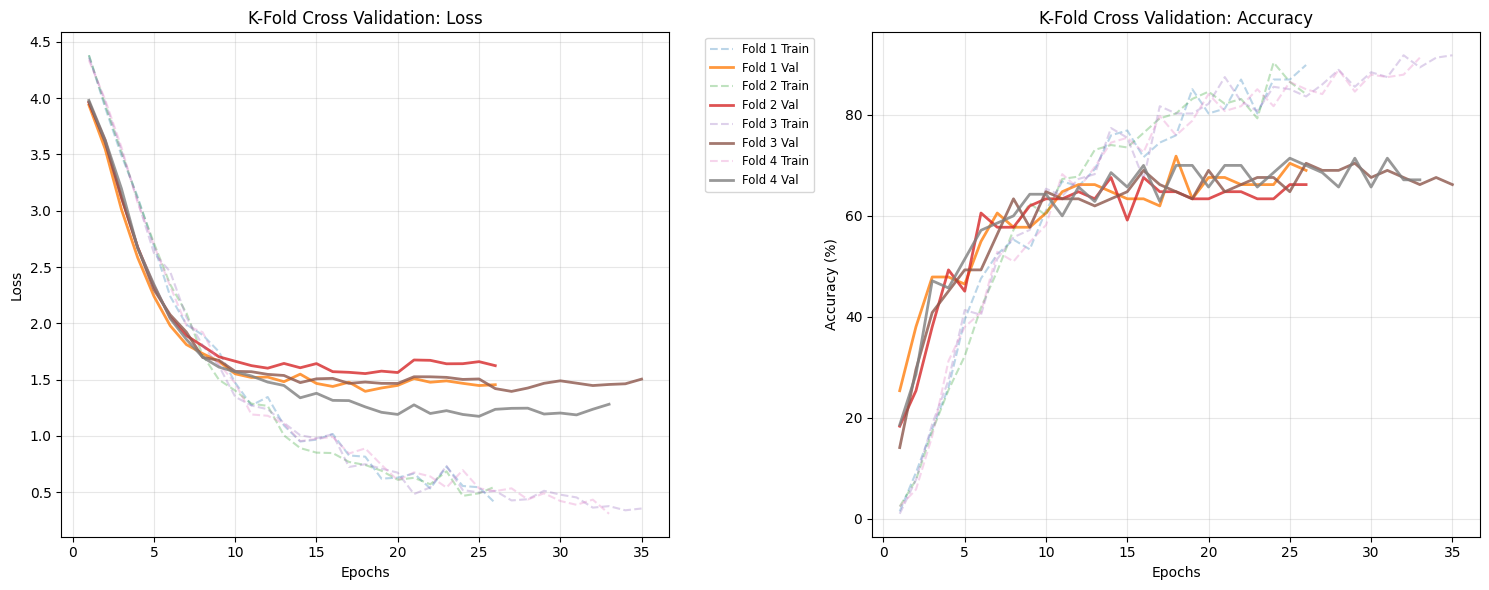

In [ ]:
def plot_kfold_history(all_histories):
    plt.figure(figsize=(15, 6))

    # --- PLOT 1: LOSS ---
    plt.subplot(1, 2, 1)
    for i, h in enumerate(all_histories):
        epochs = range(1, len(h['train_loss']) + 1)
        # Plot garis tipis untuk setiap fold
        plt.plot(epochs, h['train_loss'], alpha=0.3, linestyle='--', label=f'Fold {i+1} Train')
        plt.plot(epochs, h['val_loss'], alpha=0.8, linewidth=2, label=f'Fold {i+1} Val')

    plt.title('K-Fold Cross Validation: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    # --- PLOT 2: ACCURACY ---
    plt.subplot(1, 2, 2)
    for i, h in enumerate(all_histories):
        epochs = range(1, len(h['train_acc']) + 1)
        # Plot garis tipis untuk setiap fold
        plt.plot(epochs, h['train_acc'], alpha=0.3, linestyle='--', label=f'Fold {i+1} Train')
        plt.plot(epochs, h['val_acc'], alpha=0.8, linewidth=2, label=f'Fold {i+1} Val')

    plt.title('K-Fold Cross Validation: Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, alpha=0.3)
    # plt.legend() # Legend dimatikan di kanan agar tidak penuh

    plt.tight_layout()
    plt.show()

# Jalankan plotting
plot_kfold_history(all_folds_history)

In [ ]:
print("\n=== AGGREGATED CLASSIFICATION REPORT (Semua Folds) ===")

# Gunakan np.arange agar tidak error jika ada kelas yang hilang
all_indices = np.arange(len(class_names))

print(classification_report(
    global_true_labels,
    global_pred_labels,
    labels=all_indices,
    target_names=class_names,
    zero_division=0
))


=== AGGREGATED CLASSIFICATION REPORT (Semua Folds) ===
                                 precision    recall  f1-score   support

             Nasya Aulia Efendi       0.25      0.25      0.25         4
           Abraham Ganda Napitu       0.40      0.50      0.44         4
       Abu Bakar Siddiq Siregar       0.80      1.00      0.89         4
             Ahmad Faqih Hasani       1.00      0.50      0.67         4
                   Aldi Sanjaya       0.75      0.75      0.75         4
                        Alfajar       0.80      1.00      0.89         4
            Alief Fathur Rahman       1.00      0.25      0.40         4
 Arkan Hariz Chandrawinata Liem       0.67      1.00      0.80         4
               Bayu Ega Ferdana       0.00      0.00      0.00         4
          Bayu Prameswara Haris       0.00      0.00      0.00         4
           Bezalel Samuel Manik       1.00      1.00      1.00         4
           Bintang Fikri Fauzan       0.29      0.50      0.36     


=== AGGREGATED CONFUSION MATRIX ===


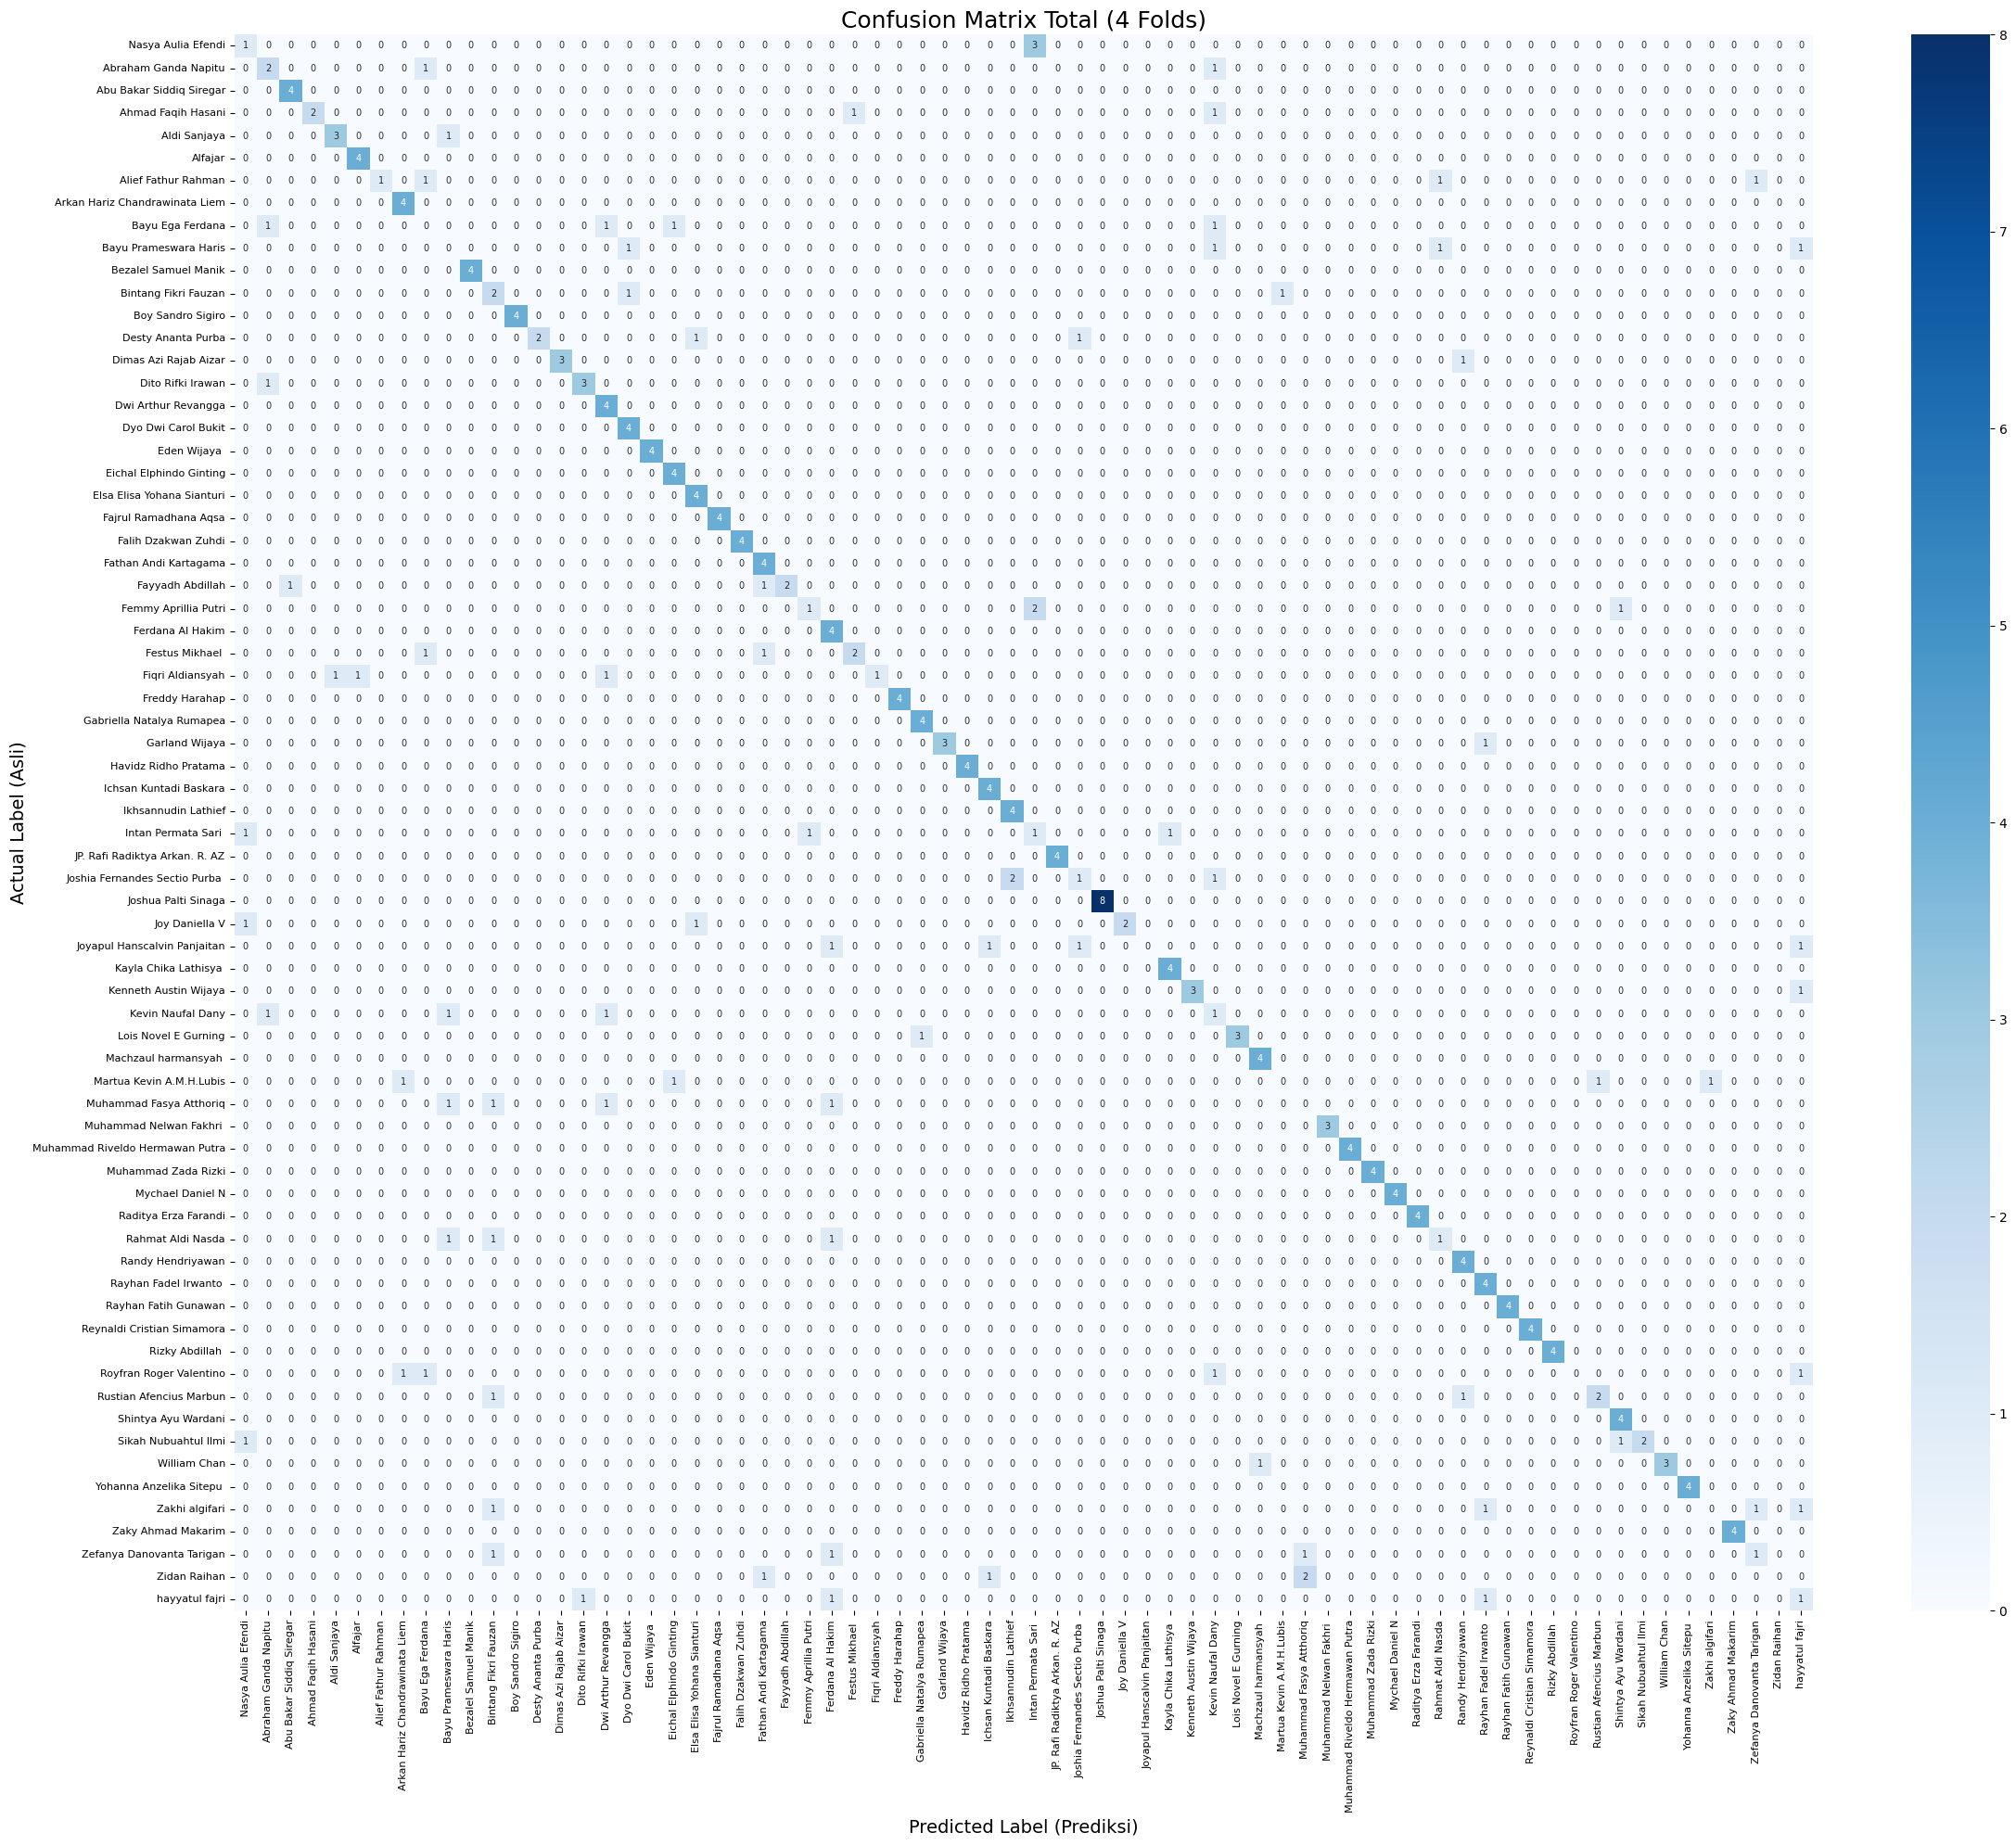

In [ ]:
print("\n=== AGGREGATED CONFUSION MATRIX ===")

cm = confusion_matrix(global_true_labels, global_pred_labels, labels=all_indices)

# Karena 70 kelas, kita buat plot yang SANGAT BESAR
plt.figure(figsize=(24, 20)) # Ukuran kanvas besar

sns.heatmap(
    cm,
    annot=True,           # Tampilkan angka
    fmt='d',              # Format angka bulat
    cmap='Blues',         # Warna biru
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 7} # Perkecil ukuran font angka agar muat
)

plt.ylabel('Actual Label (Asli)', fontsize=14)
plt.xlabel('Predicted Label (Prediksi)', fontsize=14)
plt.title(f'Confusion Matrix Total ({K_FOLDS} Folds)', fontsize=18)
plt.xticks(rotation=90, fontsize=8) # Putar label nama agar terbaca
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()